#### Cancer Detection
Split into smaller problems

- CT scans: 3D array of single channel data
- Voxel: 3D equivalent to pixel

#### [The Luna16 Dataset](https://luna16.grand-challenge.org/download/) (is big)

- Raw CT files (.raw)
- Metadata (.mhd)

Combine the two and create a 3D array, and the transformation matrix to convert from patient
coordinate system to index, row, column

- candidates.csv: information about lumps that are potentially nodules. (0 is not nodule, 1 is)
- annotations.csv: information about lumps that are potentially nodules. (data about the candidates: seriesuid,coordX,coordY,coordZ,diameter_m)

#### Validation Set:
Sort nodules by size, pick every Nth for validation set
Locations on two .csvs don't line up exactly soo they need lining up.

- Conversion from voxel to xyz
    - Flip the coordinates from IRC to CRI, to align with XYZ.
    - Scale the indices with the voxel sizes.
    - Matrix-multiply with the directions matrix, using @ in Python.
    - Add the offset for the origin

In [12]:
%matplotlib inline
import numpy as np

from  cancer_detector.dsets import getCandidateInfoList, getCt, LunaDataset


In [13]:
candidateInfo_list = getCandidateInfoList(requireOnDisk_bool=False)
positiveInfo_list = [x for x in candidateInfo_list if x[0]]
diameter_list = [x[1] for x in positiveInfo_list]

['1.3.6.1.4.1.14519.5.2.1.6279.6001.275766318636944297772360944907', '1.3.6.1.4.1.14519.5.2.1.6279.6001.272961322147784625028175033640', '1.3.6.1.4.1.14519.5.2.1.6279.6001.134370886216012873213579659366', '1.3.6.1.4.1.14519.5.2.1.6279.6001.173106154739244262091404659845', '1.3.6.1.4.1.14519.5.2.1.6279.6001.270390050141765094612147226290', '1.3.6.1.4.1.14519.5.2.1.6279.6001.161002239822118346732951898613', '1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636438705059720603192', '1.3.6.1.4.1.14519.5.2.1.6279.6001.768276876111112560631432843476', '1.3.6.1.4.1.14519.5.2.1.6279.6001.674809958213117379592437424616', '1.3.6.1.4.1.14519.5.2.1.6279.6001.335866409407244673864352309754', '1.3.6.1.4.1.14519.5.2.1.6279.6001.259543921154154401875872845498', '1.3.6.1.4.1.14519.5.2.1.6279.6001.171919524048654494439256263785', '1.3.6.1.4.1.14519.5.2.1.6279.6001.108231420525711026834210228428', '1.3.6.1.4.1.14519.5.2.1.6279.6001.197987940182806628828566429132', '1.3.6.1.4.1.14519.5.2.1.6279.6001.231834776365

In [14]:
print(len(candidateInfo_list))
print(len(getCandidateInfoList(requireOnDisk_bool=True)))
print(len(positiveInfo_list))
print(positiveInfo_list[0])

551065
['1.3.6.1.4.1.14519.5.2.1.6279.6001.275766318636944297772360944907', '1.3.6.1.4.1.14519.5.2.1.6279.6001.272961322147784625028175033640', '1.3.6.1.4.1.14519.5.2.1.6279.6001.134370886216012873213579659366', '1.3.6.1.4.1.14519.5.2.1.6279.6001.173106154739244262091404659845', '1.3.6.1.4.1.14519.5.2.1.6279.6001.270390050141765094612147226290', '1.3.6.1.4.1.14519.5.2.1.6279.6001.161002239822118346732951898613', '1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636438705059720603192', '1.3.6.1.4.1.14519.5.2.1.6279.6001.768276876111112560631432843476', '1.3.6.1.4.1.14519.5.2.1.6279.6001.674809958213117379592437424616', '1.3.6.1.4.1.14519.5.2.1.6279.6001.335866409407244673864352309754', '1.3.6.1.4.1.14519.5.2.1.6279.6001.259543921154154401875872845498', '1.3.6.1.4.1.14519.5.2.1.6279.6001.171919524048654494439256263785', '1.3.6.1.4.1.14519.5.2.1.6279.6001.108231420525711026834210228428', '1.3.6.1.4.1.14519.5.2.1.6279.6001.197987940182806628828566429132', '1.3.6.1.4.1.14519.5.2.1.6279.6001.23183

384840
1351
CandidateInfoTuple(isNodule_bool=True, diameter_mm=32.27003025, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886', center_xyz=(67.61451718, 85.02525992, -109.8084416))


In [15]:
for i in range(0, len(diameter_list), 100):
    print('{:4}  {:4.1f} mm'.format(i, diameter_list[i]))

   0  32.3 mm
 100  17.7 mm
 200  13.0 mm
 300  10.0 mm
 400   8.2 mm
 500   7.0 mm
 600   6.3 mm
 700   5.7 mm
 800   5.1 mm
 900   4.7 mm
1000   4.0 mm
1100   0.0 mm
1200   0.0 mm
1300   0.0 mm


In [16]:
for candidateInfo_tup in positiveInfo_list[:10]:
    print(candidateInfo_tup)
for candidateInfo_tup in positiveInfo_list[-10:]:
    print(candidateInfo_tup)

for candidateInfo_tup in positiveInfo_list:
    if candidateInfo_tup.series_uid.endswith('565'):
        print(candidateInfo_tup)

CandidateInfoTuple(isNodule_bool=True, diameter_mm=32.27003025, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886', center_xyz=(67.61451718, 85.02525992, -109.8084416))
CandidateInfoTuple(isNodule_bool=True, diameter_mm=30.61040636, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.112740418331256326754121315800', center_xyz=(47.90350511, 37.60442008, -99.93417567))
CandidateInfoTuple(isNodule_bool=True, diameter_mm=30.61040636, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.112740418331256326754121315800', center_xyz=(44.19, 37.79, -107.01))
CandidateInfoTuple(isNodule_bool=True, diameter_mm=30.61040636, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.112740418331256326754121315800', center_xyz=(40.69, 32.19, -97.15))
CandidateInfoTuple(isNodule_bool=True, diameter_mm=27.44242293, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.943403138251347598519939390311', center_xyz=(-45.29440163, 74.86925386, -97.52812481))
CandidateInfoTuple(isNodule_bool=True, diameter_mm=27.

In [17]:
np.histogram(diameter_list)

(array([323, 466, 248, 111,  71,  57,  37,  29,   5,   4]),
 array([ 0.        ,  3.22700302,  6.45400605,  9.68100907, 12.9080121 ,
        16.13501512, 19.36201815, 22.58902117, 25.8160242 , 29.04302722,
        32.27003025]))

In [18]:
from cancer_detector.vis import findPositiveSamples, showCandidate
positiveSample_list = findPositiveSamples()

['1.3.6.1.4.1.14519.5.2.1.6279.6001.275766318636944297772360944907', '1.3.6.1.4.1.14519.5.2.1.6279.6001.272961322147784625028175033640', '1.3.6.1.4.1.14519.5.2.1.6279.6001.134370886216012873213579659366', '1.3.6.1.4.1.14519.5.2.1.6279.6001.173106154739244262091404659845', '1.3.6.1.4.1.14519.5.2.1.6279.6001.270390050141765094612147226290', '1.3.6.1.4.1.14519.5.2.1.6279.6001.161002239822118346732951898613', '1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636438705059720603192', '1.3.6.1.4.1.14519.5.2.1.6279.6001.768276876111112560631432843476', '1.3.6.1.4.1.14519.5.2.1.6279.6001.674809958213117379592437424616', '1.3.6.1.4.1.14519.5.2.1.6279.6001.335866409407244673864352309754', '1.3.6.1.4.1.14519.5.2.1.6279.6001.259543921154154401875872845498', '1.3.6.1.4.1.14519.5.2.1.6279.6001.171919524048654494439256263785', '1.3.6.1.4.1.14519.5.2.1.6279.6001.108231420525711026834210228428', '1.3.6.1.4.1.14519.5.2.1.6279.6001.197987940182806628828566429132', '1.3.6.1.4.1.14519.5.2.1.6279.6001.231834776365

2021-03-09 22:13:48,335 INFO     pid:11265 cancer_detector.dsets:180:__init__ <cancer_detector.dsets.LunaDataset object at 0x7f712ef77470>: 384840 training samples


0 CandidateInfoTuple(isNodule_bool=True, diameter_mm=32.27003025, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886', center_xyz=(67.61451718, 85.02525992, -109.8084416))
1 CandidateInfoTuple(isNodule_bool=True, diameter_mm=30.61040636, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.112740418331256326754121315800', center_xyz=(47.90350511, 37.60442008, -99.93417567))
2 CandidateInfoTuple(isNodule_bool=True, diameter_mm=30.61040636, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.112740418331256326754121315800', center_xyz=(44.19, 37.79, -107.01))
3 CandidateInfoTuple(isNodule_bool=True, diameter_mm=30.61040636, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.112740418331256326754121315800', center_xyz=(40.69, 32.19, -97.15))
4 CandidateInfoTuple(isNodule_bool=True, diameter_mm=27.44242293, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.943403138251347598519939390311', center_xyz=(-45.29440163, 74.86925386, -97.52812481))
5 CandidateInfoTuple(isNodule_bool=True, dia

2021-03-09 22:13:49,567 INFO     pid:11265 cancer_detector.dsets:180:__init__ <cancer_detector.dsets.LunaDataset object at 0x7f712ef68438>: 502 training samples


1.3.6.1.4.1.14519.5.2.1.6279.6001.316900421002460665752357657094 0 False [0, 1, 2, 3]


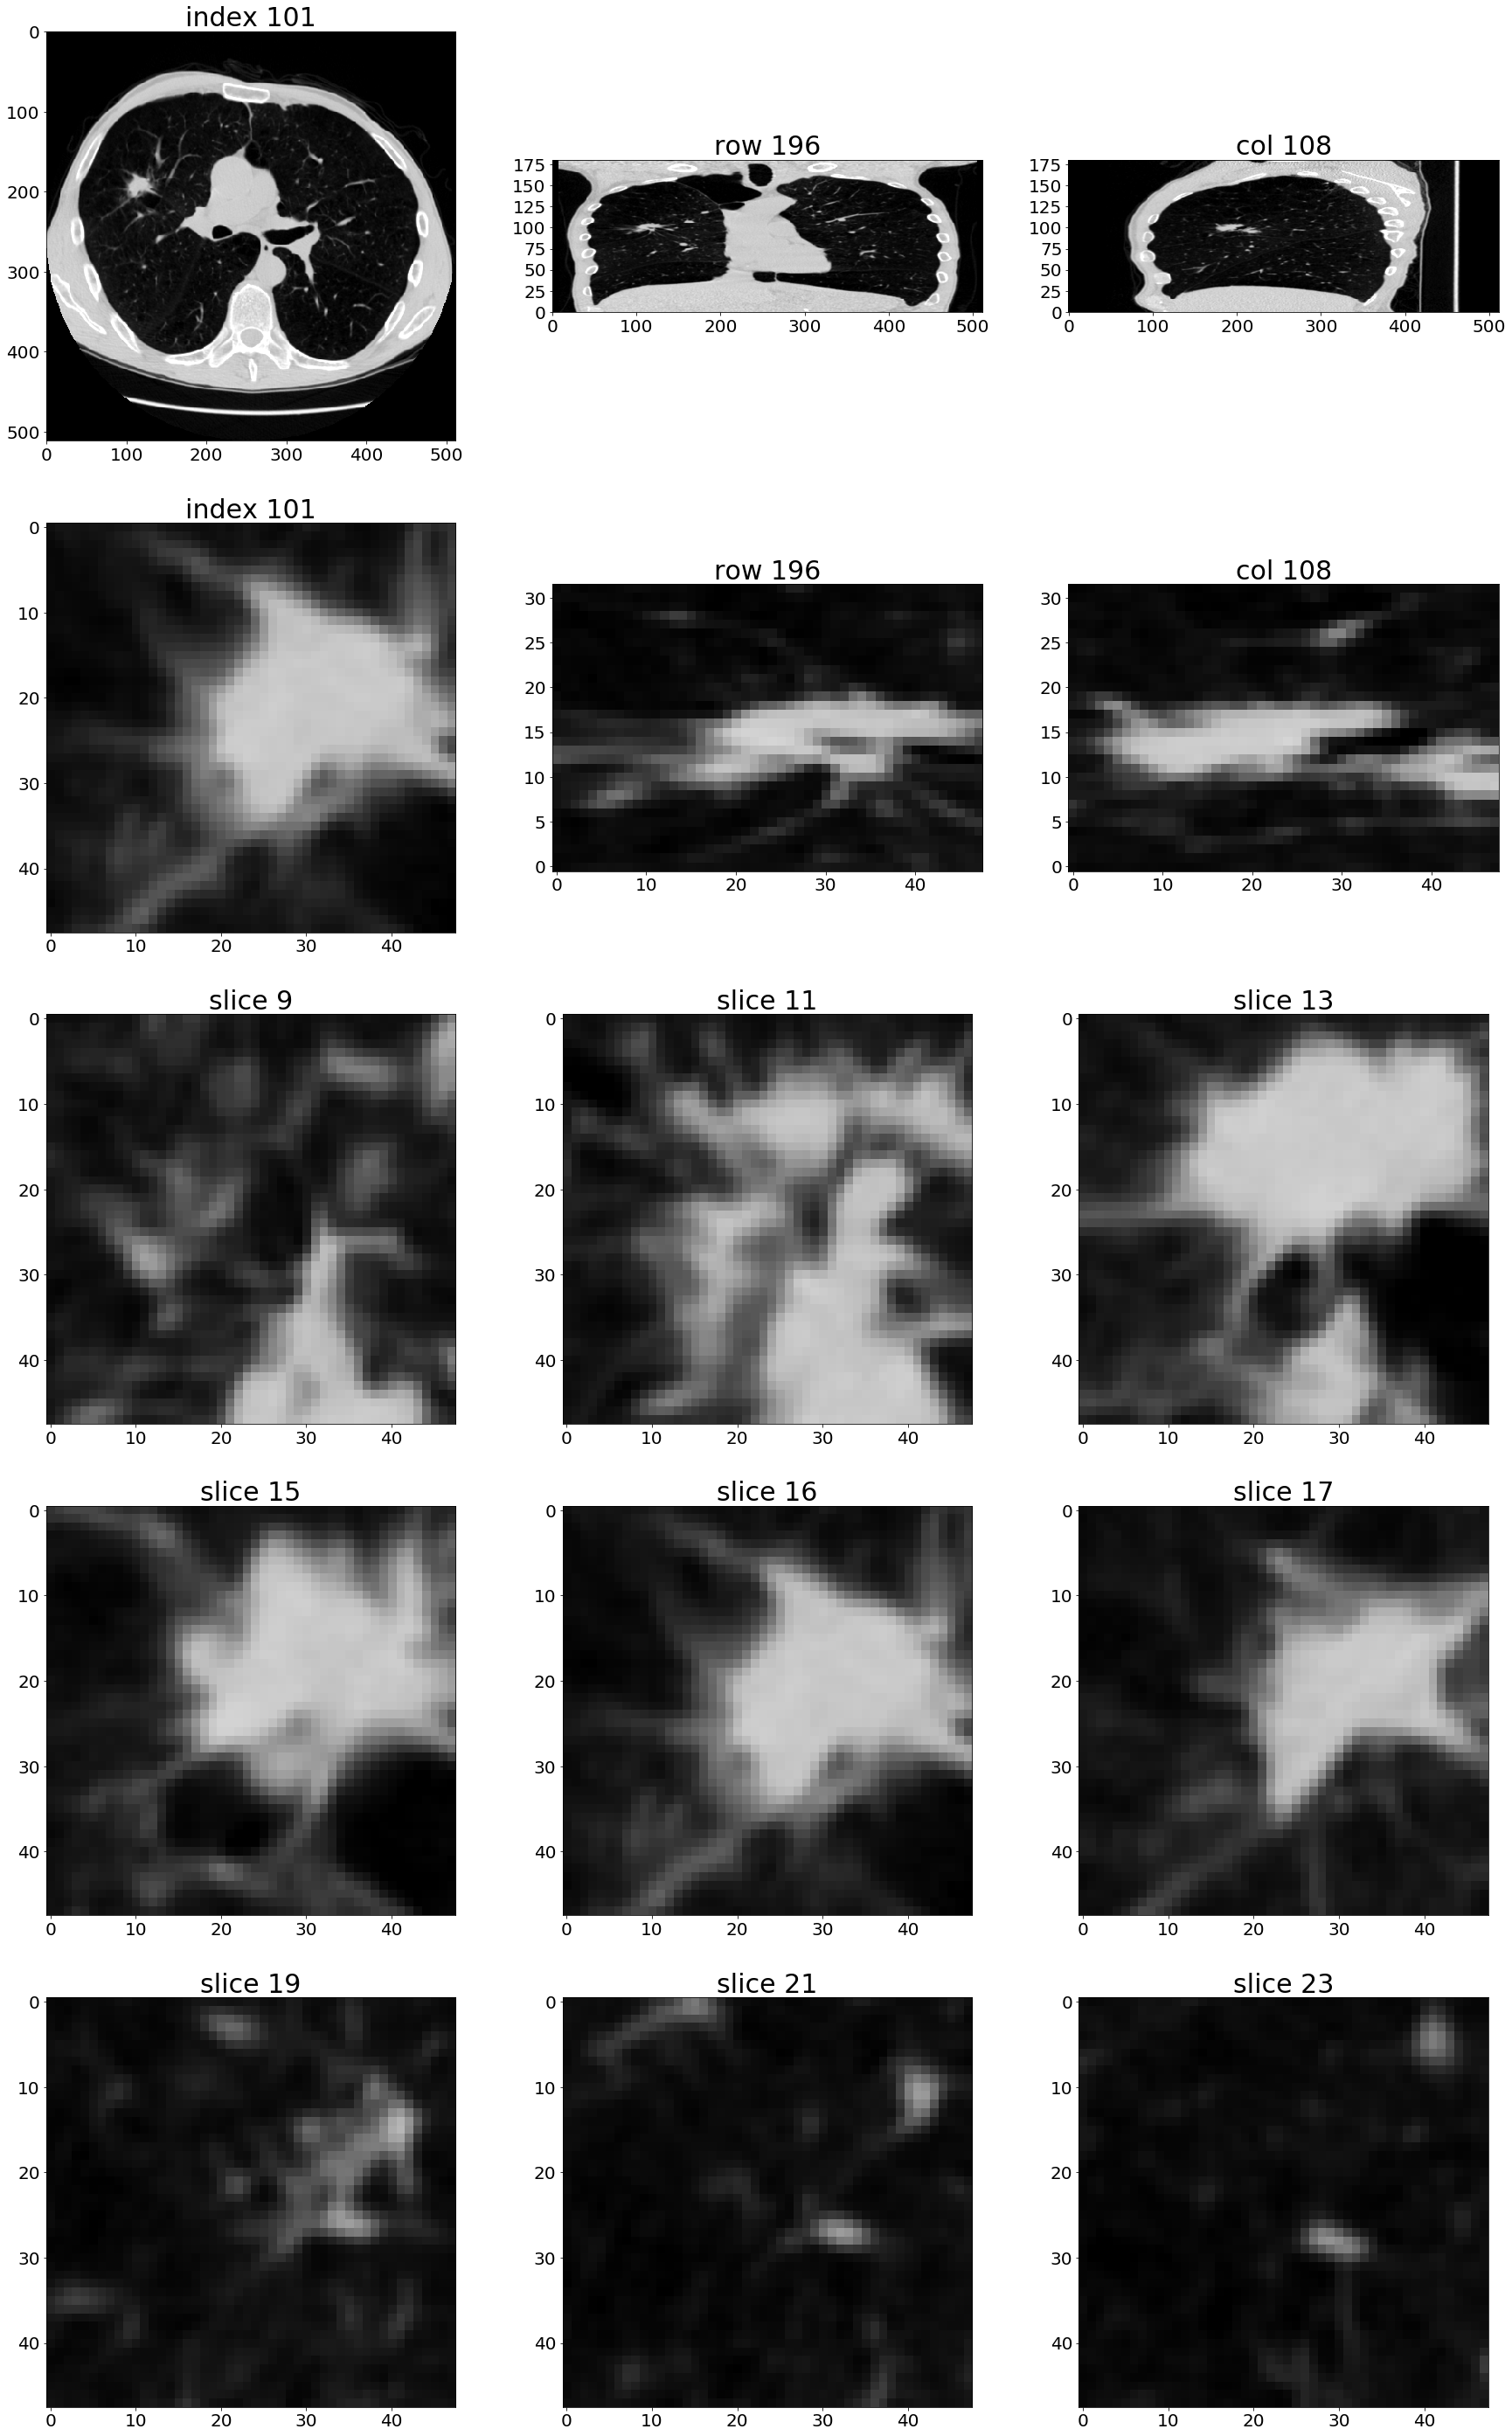

In [19]:
series_uid = positiveSample_list[11][2]
showCandidate(series_uid)

2021-03-09 22:13:52,322 INFO     pid:11265 cancer_detector.dsets:180:__init__ <cancer_detector.dsets.LunaDataset object at 0x7f7110a19b38>: 1061 training samples


1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048929153767743874565 0 False [0]


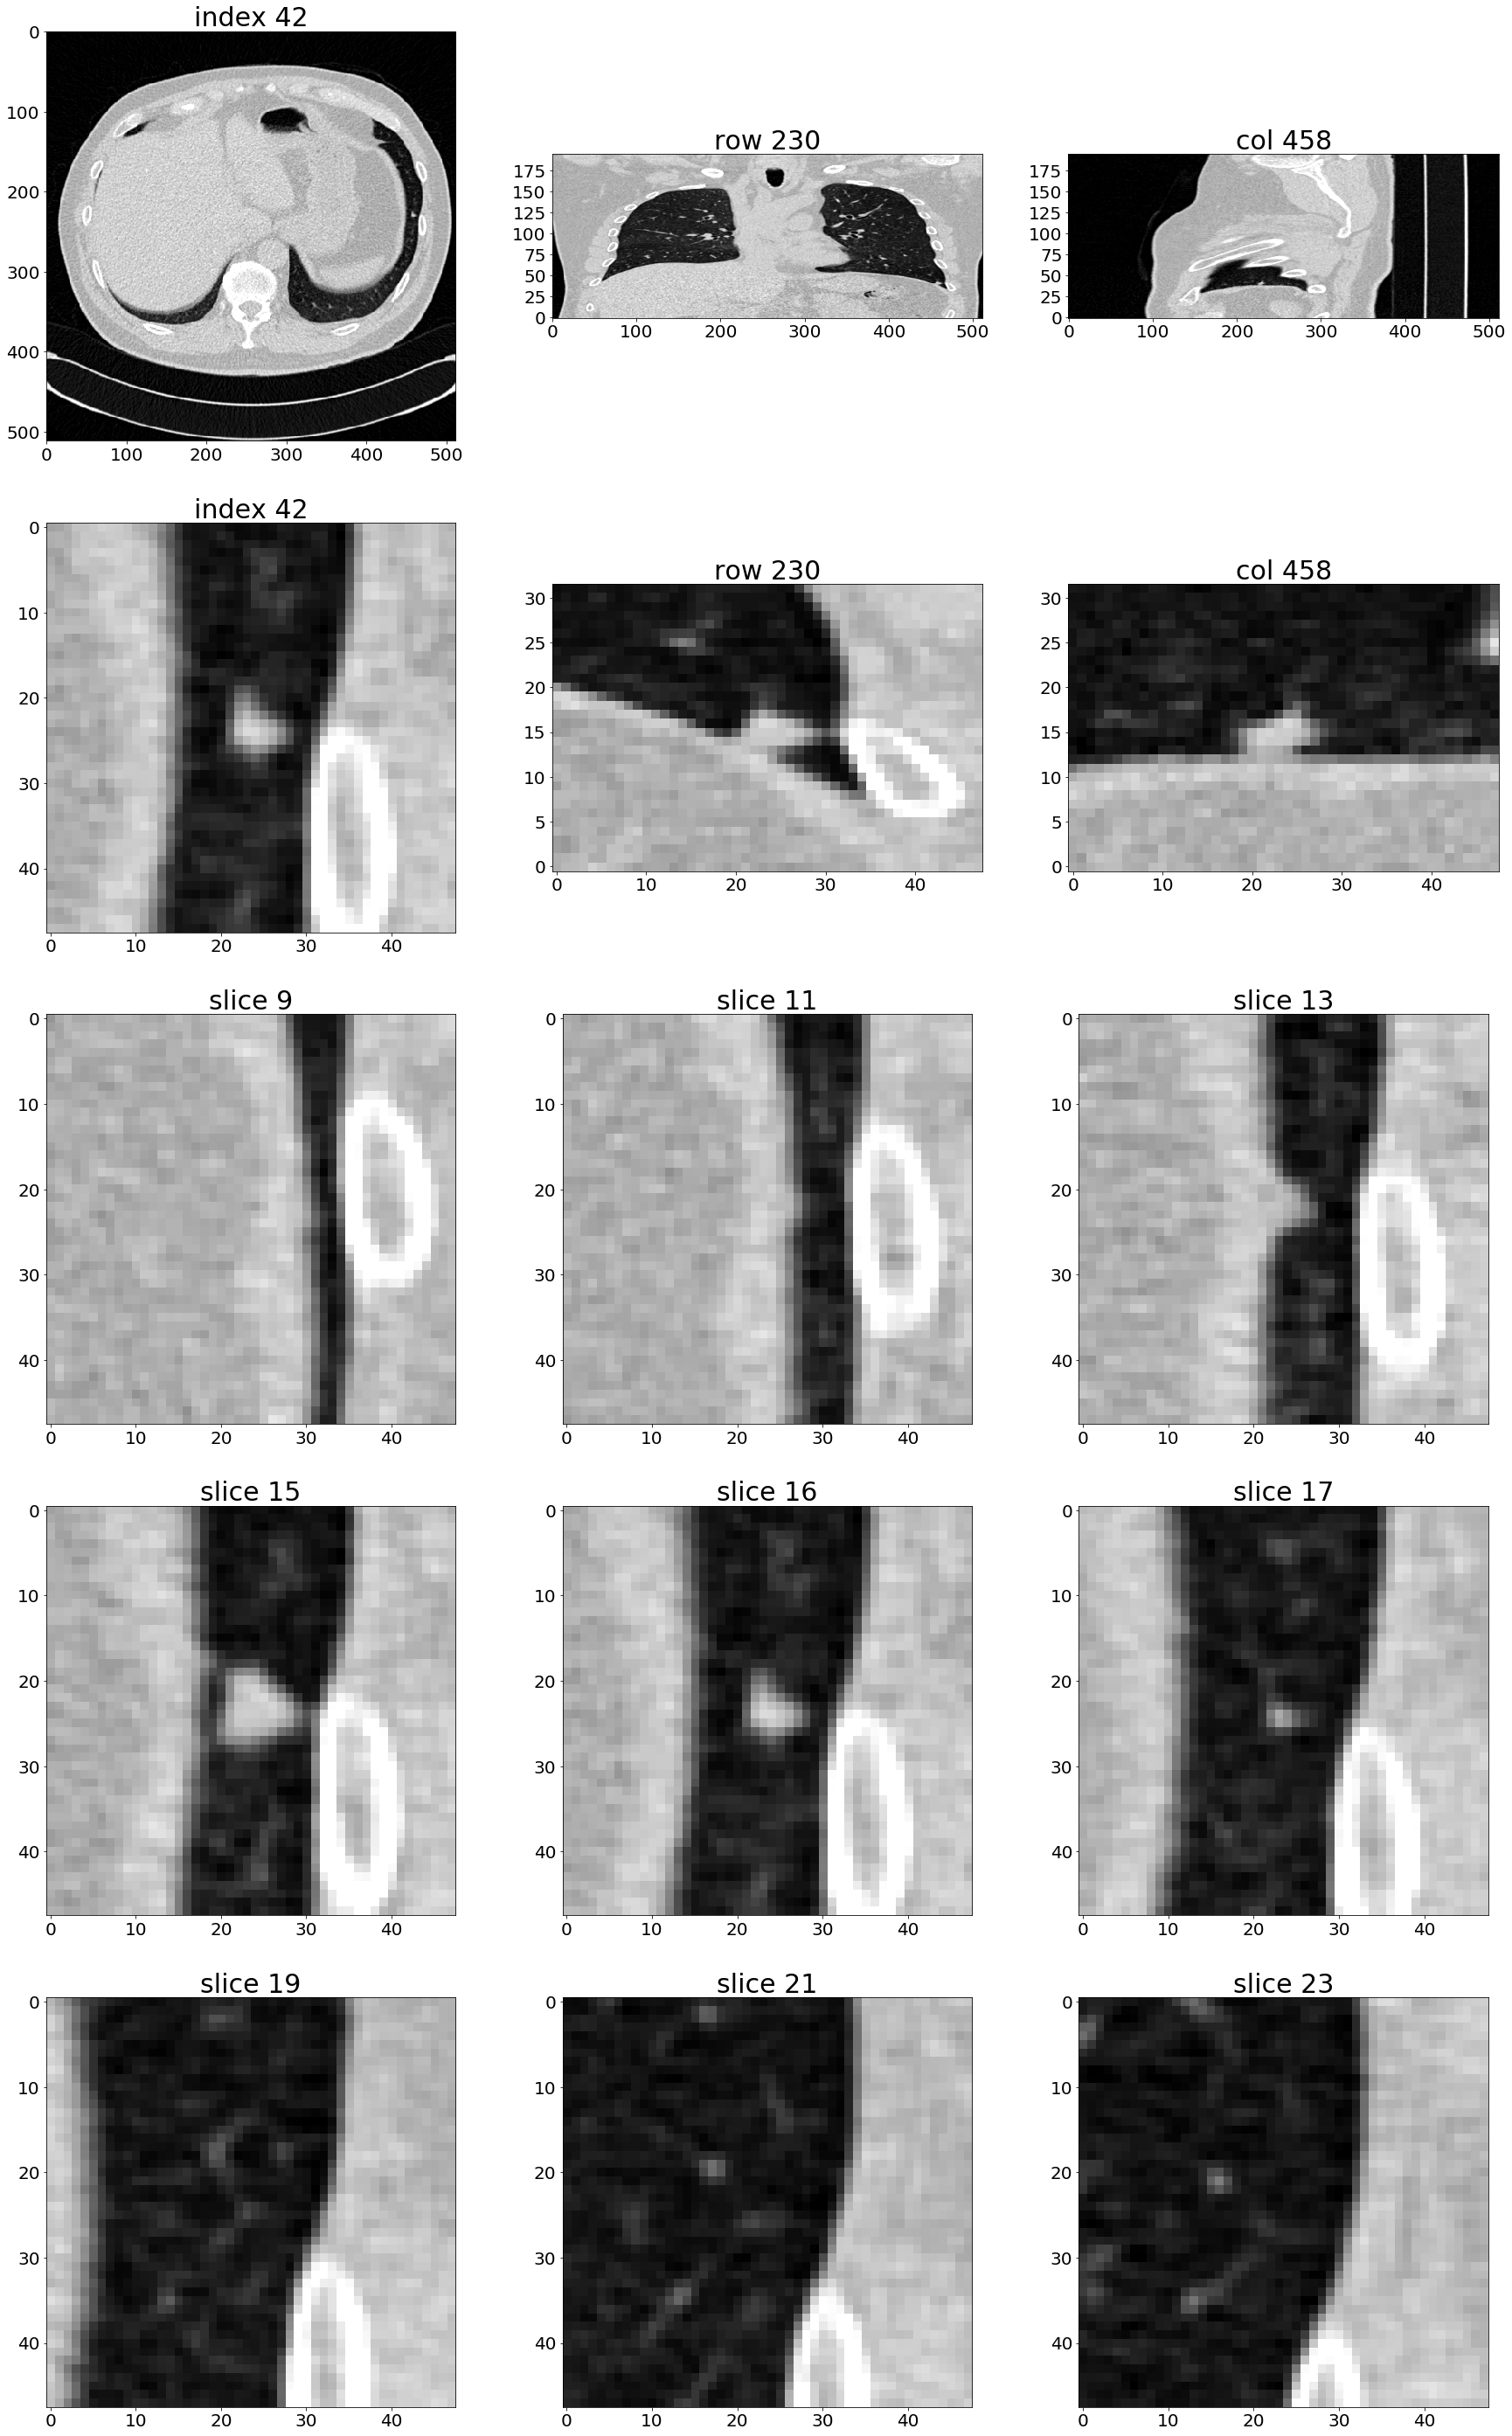

In [20]:
series_uid = '1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048929153767743874565'
showCandidate(series_uid)

2021-03-09 22:14:03,816 INFO     pid:11265 cancer_detector.dsets:180:__init__ <cancer_detector.dsets.LunaDataset object at 0x7f711da703c8>: 605 training samples


1.3.6.1.4.1.14519.5.2.1.6279.6001.126264578931778258890371755354 0 False [0]


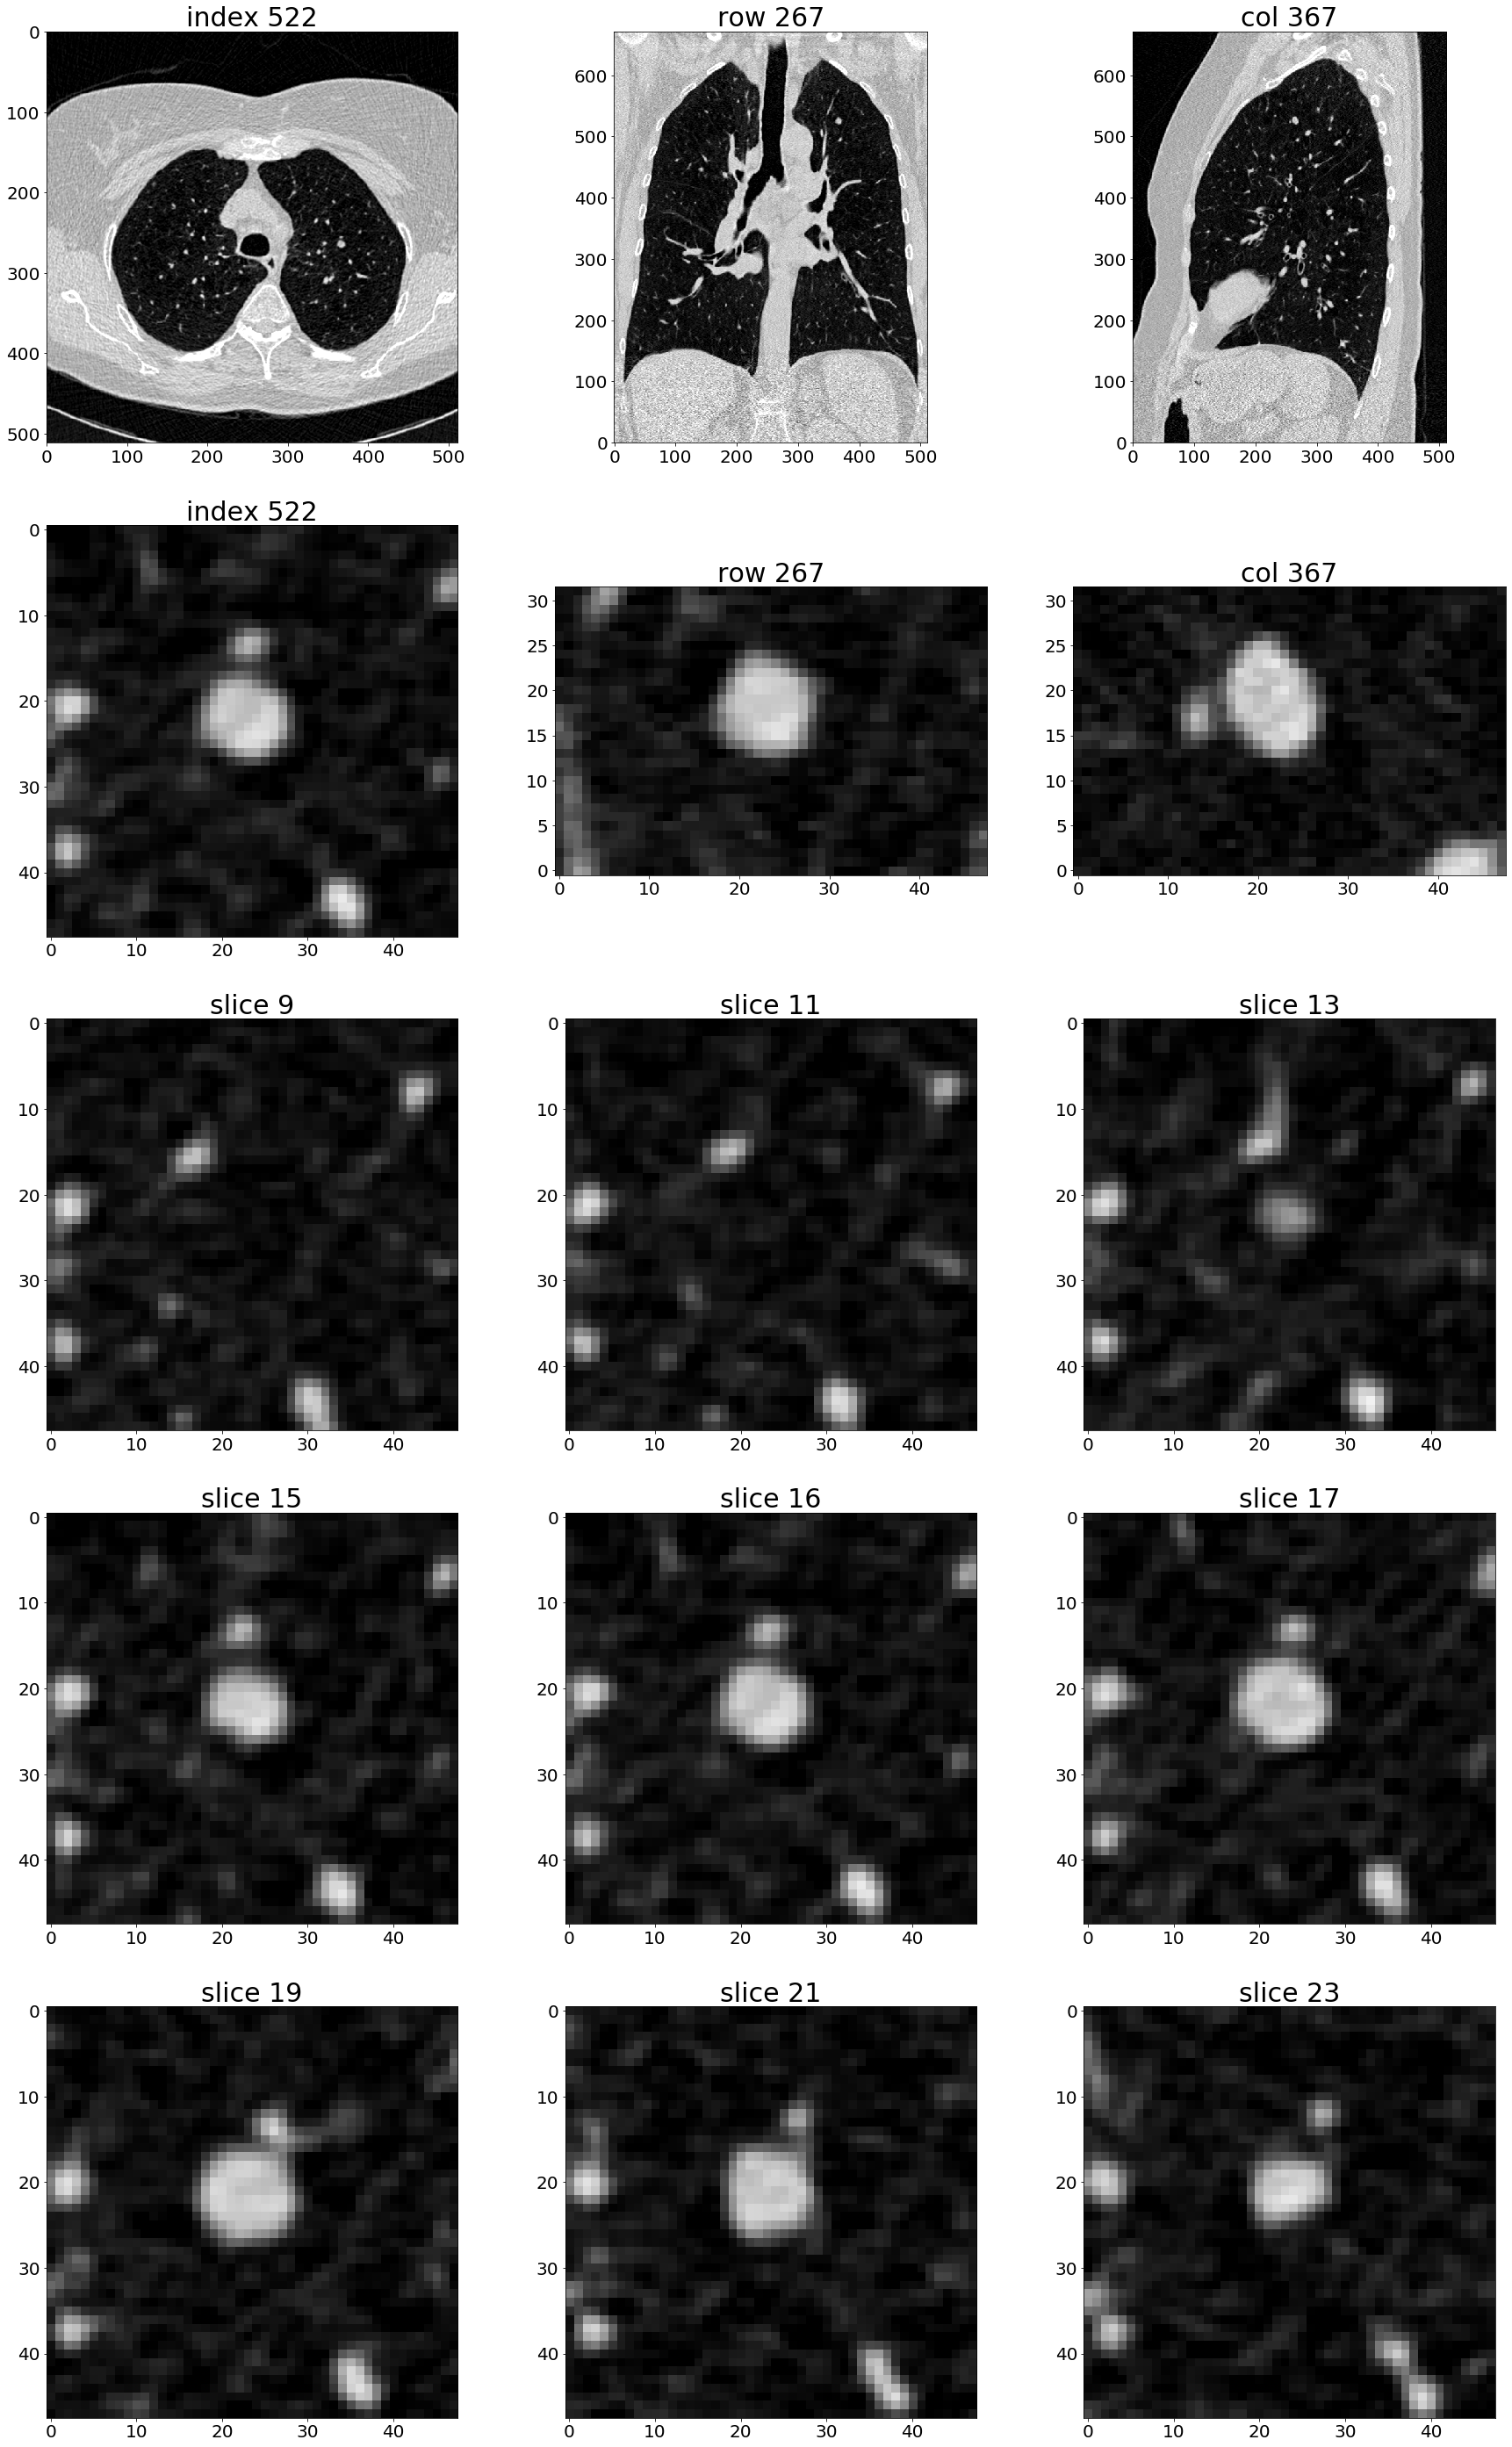

In [21]:
series_uid = '1.3.6.1.4.1.14519.5.2.1.6279.6001.126264578931778258890371755354'
showCandidate(series_uid)
